### Forecast tidal window
When can my vessel enter the port and travel until the berth?

#### Problem
##### <b>Part 1</b>
<p>Consider the scenario of a marine vessel which is entering a port area and attempting to navigate to a safe berth, in order to load or discharge its cargo.</p>

At any time, a vessel will have a certain <i>draught</i> - the depth that the vessel is sitting in the water. Laden vessels will often have such a deep draught that, until they can reach a berth and begin to discharge their cargo, they will only be able to navigate safely at high tide. In other words, the port area will have a baseline water depth, and the height of the tide is added to this baseline to give the total water depth at any given time.

Your task is to create a feature that will help a vessel operator know precisely when their vessel will be affected by tidal restrictions on arrival to the port. This feature should be in the form of a Python API. This API should accept the following request parameters:

The arrival port identifier
The vessel characteristics
The date and time of arrival
In response, the API should return all the tidal windows for the next 14 days from the arrival time. That is, it should contain all the information needed to classify any time in the next 14 days from the arrival time as "in" or "out" of a tide window.

Note: The tide data is already a forecast and is available for 14+ days ahead. In other words, you do not need to predict the tides - just use the tide forecast and the draught information to construct the tidal windows.

Data
The dataset `tide_heights.csv` contains, for several distinct ports, the highest and lowest points of each tide - it is up to you how to interpolate between these high and low points.

In addition, you are provided with two other datasets: `ports.csv`, which contains information about each port in your tide dataset, and `vessels.csv`, which gives a list of example vessels to help you test your code.

##### <b>Part 2</b>
<p>In addition to tidal restrictions, some ports also restrict passage through the port area during nighttime, due to the reduced visibility of potential hazards. In order for a vessel to be permitted to go to the berth, it needs to comply with both tidal and daylight restrictions.</p>

This time you are invited to find your own source of daylight information for each port, and create a second API which now returns the overall restriction windows for the next 14 days from the arrival time - combining both tidal and daylight restrictions.

##### <b>Part 3</b>
<p>You've created the API - now to explain to the business side how the calculation works. Produce one or more charts with an example scenario of an arriving vessel to a port - displaying the tidal variation, the draught of the vessel, and the tidal or overall restrictions window clearly evident from the chart. The choice of visualization tool is up to you.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import math
from ipywidgets import interactive, widgets
import IPython.display as display

In [5]:
# Importing files
tide_heights = pd.read_csv('../../data/tide_heights.csv')
ports = pd.read_csv('../../data/ports.csv')
vessels = pd.read_csv('../../data/vessels.csv')

# Let's see what we have
print("VESSELS DATA:")
print(vessels.head())
print("\nVESSELS COLUMNS:", vessels.columns.tolist())

print("\nPORTS DATA:")
print(ports.head())
print("\nPORTS COLUMNS:", ports.columns.tolist())

print("\nTIDE HEIGHTS DATA:")
print(tide_heights.head())
print("\nTIDE HEIGHTS COLUMNS:", tide_heights.columns.tolist())

# Basic information about our datasets
print("\nNumber of unique ports:", tide_heights['PORT_NAME'].nunique())
print("Date range in tide data:")
print("Start:", tide_heights['TIDE_DATETIME'].min())
print("End:", tide_heights['TIDE_DATETIME'].max())

VESSELS DATA:
   Unnamed: 0      IMO  DRAUGHT         NAME      DWT
0           0  9790933   13.418   UNITY LIFE  63482.0
1           1  9331866   12.573     MING HUA  55682.0
2           2  9251315   12.020  VIVA GLOBUS  52300.0
3           3  9494008   14.430     VELSHEDA  82172.0
4           4  9461128   14.429     NEA TYHI  82211.0

VESSELS COLUMNS: ['Unnamed: 0', 'IMO', 'DRAUGHT', 'NAME', 'DWT']

PORTS DATA:
   Unnamed: 0         NAME   LATITUDE   LONGITUDE UNLOCODE  \
0           0  Abbot Point -19.859141  148.083663    AUABP   
1           1     Brisbane -27.376286  153.163766    AUBNE   
2           2     Cooktown -15.459552  145.249484    AUCTN   
3           3      Dampier -20.663411  116.701119    AUDAM   

   APPROACH_MLLW_METERS  
0                  17.2  
1                  14.0  
2                  14.1  
3                  14.6  

PORTS COLUMNS: ['Unnamed: 0', 'NAME', 'LATITUDE', 'LONGITUDE', 'UNLOCODE', 'APPROACH_MLLW_METERS']

TIDE HEIGHTS DATA:
   TIDE_HEIGHT_ID    P

Vessels Data (`vessels.csv`):

We have vessel information including DRAUGHT
DRAUGHTs range from ~12m to ~14.5m
Each vessel has a unique IMO number


Ports Data (`ports.csv`):

4 ports: Abbot Point, Brisbane, Cooktown, and Dampier
Each has a baseline depth (APPROACH_MLLW_METERS)
Abbot Point has deepest approach at 17.2m


Tide Heights Data (`tide_heights.csv`):

Covers March 2024 to August 2024
Contains HIGH and LOW tide points
Has tide heights in meters

I will start with a sample of the problem:

- One port (say Abbot Point)
- One vessel (UNITY LIFE with 13.418m draught)
- One day of data

In [6]:
# Some pre-processing
tide_heights['TIDE_DATETIME'] = pd.to_datetime(tide_heights['TIDE_DATETIME'])

# The example: 
# One day of data for Abbot Point
port_name = "Abbot Point"
start_date = '2024-03-01'
end_date = '2024-03-02'

port_tides = tide_heights[
    (tide_heights['PORT_NAME'] == port_name) & 
    (tide_heights['TIDE_DATETIME'].dt.date >= pd.to_datetime(start_date).date()) &
    (tide_heights['TIDE_DATETIME'].dt.date < pd.to_datetime(end_date).date())
].copy()

# Getting port's baseline depth
port_depth = ports[ports['NAME'] == port_name]['APPROACH_MLLW_METERS'].iloc[0]

# Calculating total water depth
port_tides['TOTAL_DEPTH'] = port_depth + port_tides['TIDE_HEIGHT_MT']

# Example vessel draught
vessel_draught = 13.418  # UNITY LIFE
port_tides


,TIDE_HEIGHT_ID,PORT_NAME,TIDE_DATETIME,TIDE_HEIGHT_MT,TIDE_TYPE,TOTAL_DEPTH
0,564218779,Abbot Point,2024-03-01 00:47:02,1.36,HIGH,18.56
1,564218780,Abbot Point,2024-03-01 06:25:59,0.97,LOW,18.17
2,564218781,Abbot Point,2024-03-01 11:59:30,1.41,HIGH,18.61
3,564218782,Abbot Point,2024-03-01 18:58:48,0.56,LOW,17.76


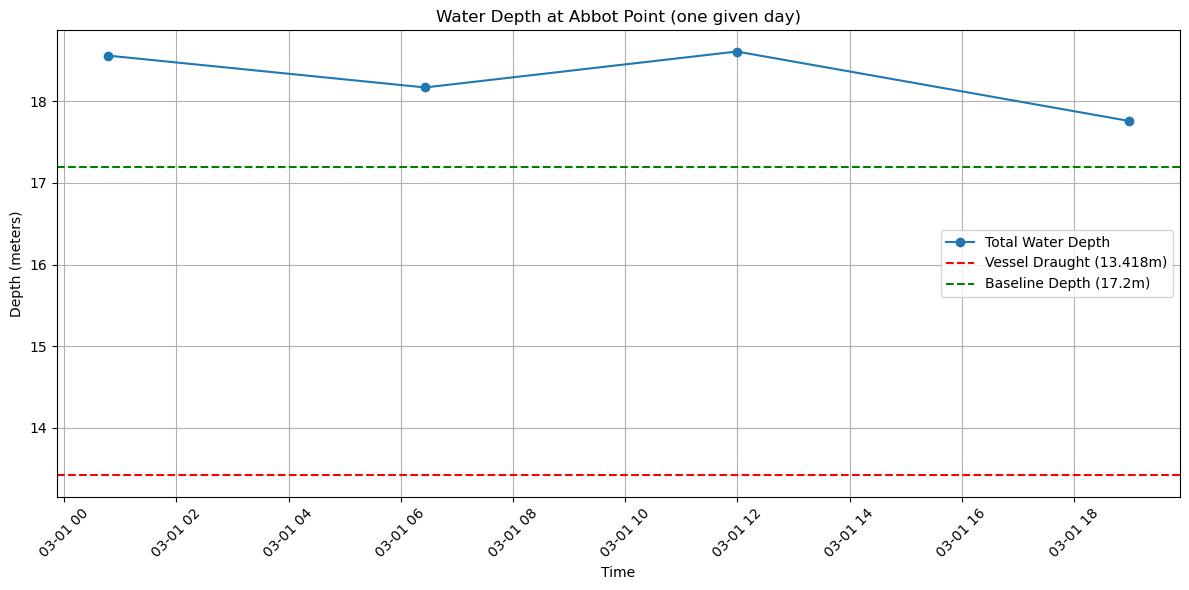


Analysis for Abbot Point on 2024-03-01:
Baseline depth (minimum water depth at the port): 17.20m
Vessel draught: 13.42m
Required safety margin: -3.78m

Tide points for this day:
        TIDE_DATETIME  TIDE_HEIGHT_MT TIDE_TYPE  TOTAL_DEPTH
0 2024-03-01 00:47:02            1.36      HIGH        18.56
1 2024-03-01 06:25:59            0.97       LOW        18.17
2 2024-03-01 11:59:30            1.41      HIGH        18.61
3 2024-03-01 18:58:48            0.56       LOW        17.76


In [7]:
# Let's take a look at the data

plt.figure(figsize=(12, 6))
plt.plot(port_tides['TIDE_DATETIME'], port_tides['TOTAL_DEPTH'], '-o', label='Total Water Depth') # depth + tidal height
plt.axhline(y=vessel_draught, color='red', linestyle='--', label=f'Vessel Draught ({vessel_draught}m)') # port's minimum water depth
plt.axhline(y=port_depth, color='green', linestyle='--', label=f'Baseline Depth ({port_depth}m)') # how deep the vessel sits in the water

plt.title(f'Water Depth at {port_name} (one given day)')
plt.xlabel('Time')
plt.ylabel('Depth (meters)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Some statistics
print(f"\nAnalysis for {port_name} on {start_date}:")
print(f"Baseline depth (minimum water depth at the port): {port_depth:.2f}m")
print(f"Vessel draught: {vessel_draught:.2f}m")
print(f"Required safety margin: {vessel_draught - port_depth:.2f}m")
print("\nTide points for this day:")
print(port_tides[['TIDE_DATETIME', 'TIDE_HEIGHT_MT', 'TIDE_TYPE', 'TOTAL_DEPTH']].to_string())

Not a very good example, the results show that UNITY LIFE only needs 13.42m of water to float and Abbot Point always has at least 17.20m of water, thus it can safely enter at any time...
Let's look for another example:

In [8]:
print(vessels[['NAME', 'DRAUGHT']].sort_values('DRAUGHT', ascending=False))

            NAME  DRAUGHT
7        JIMMY T   36.800
9    MBA ROSARIA   14.900
6      EPIPHANIA   14.450
8  HUA SHENG HAI   14.450
3       VELSHEDA   14.430
4       NEA TYHI   14.429
5       NIKOLAOS   14.210
0     UNITY LIFE   13.418
1       MING HUA   12.573
2    VIVA GLOBUS   12.020


In [9]:
print(ports[['NAME', 'APPROACH_MLLW_METERS']].sort_values('APPROACH_MLLW_METERS'))

          NAME  APPROACH_MLLW_METERS
1     Brisbane                  14.0
2     Cooktown                  14.1
3      Dampier                  14.6
0  Abbot Point                  17.2


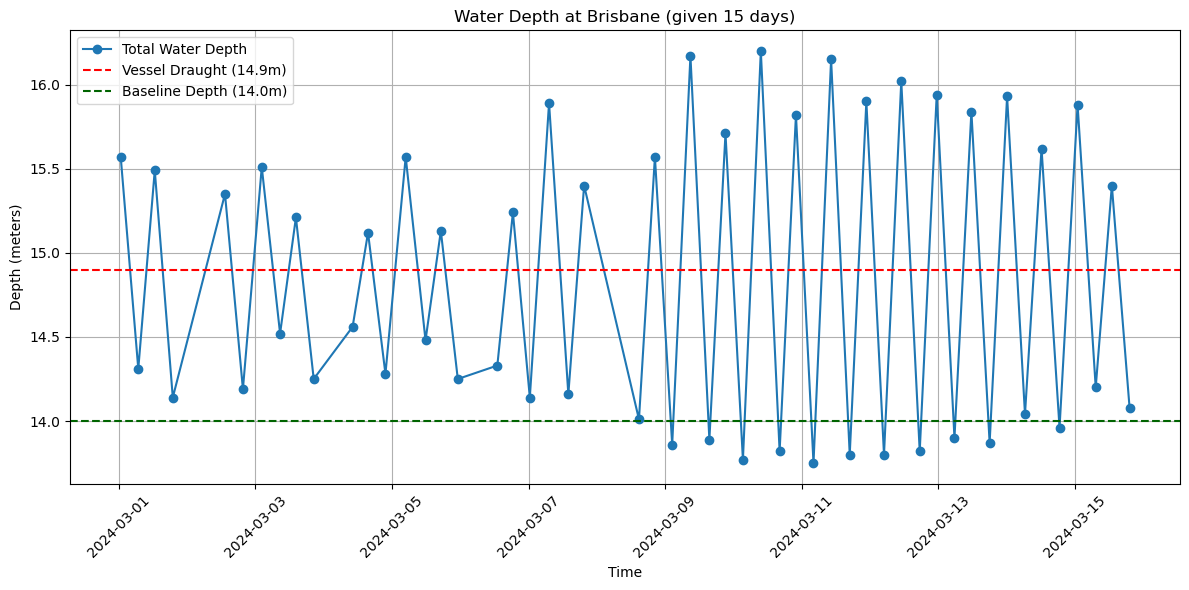


Analysis for Brisbane from 2024-03-01 to 2024-03-16:
Baseline depth (minimum water depth at the port): 14.00m
Vessel draught: 14.90m
Required safety margin: 0.90m

Tide points for this day:
          TIDE_DATETIME  TIDE_HEIGHT_MT TIDE_TYPE  TOTAL_DEPTH
577 2024-03-01 00:38:06            1.57      HIGH        15.57
578 2024-03-01 06:48:29            0.31       LOW        14.31
579 2024-03-01 12:36:02            1.49      HIGH        15.49
580 2024-03-01 18:56:17            0.14       LOW        14.14
581 2024-03-02 13:17:03            1.35      HIGH        15.35
582 2024-03-02 19:35:15            0.19       LOW        14.19
583 2024-03-03 02:12:40            1.51      HIGH        15.51
584 2024-03-03 08:39:00            0.52       LOW        14.52
585 2024-03-03 14:13:06            1.21      HIGH        15.21
586 2024-03-03 20:28:19            0.25       LOW        14.25
587 2024-03-04 10:08:28            0.56       LOW        14.56
588 2024-03-04 15:33:48            1.12      HIGH    

In [10]:
# This example: 

port_name = "Brisbane" # changing the port too, since Abott seems to be quite deep
start_date = '2024-03-01'
end_date = '2024-03-16' # also extending the days to see the effect of the tides

port_tides = tide_heights[
    (tide_heights['PORT_NAME'] == port_name) & 
    (tide_heights['TIDE_DATETIME'].dt.date >= pd.to_datetime(start_date).date()) &
    (tide_heights['TIDE_DATETIME'].dt.date < pd.to_datetime(end_date).date())
].copy()

# Getting port's baseline depth
port_depth = ports[ports['NAME'] == port_name]['APPROACH_MLLW_METERS'].iloc[0]

# Calculating total water depth
port_tides['TOTAL_DEPTH'] = port_depth + port_tides['TIDE_HEIGHT_MT']

# Example vessel draught
vessel_draught = 14.900  # MBA ROSARIA

plt.figure(figsize=(12, 6))
plt.plot(port_tides['TIDE_DATETIME'], port_tides['TOTAL_DEPTH'], '-o', label='Total Water Depth') # depth + tidal height
plt.axhline(y=vessel_draught, color='red', linestyle='--', label=f'Vessel Draught ({vessel_draught}m)') # port's minimum water depth
plt.axhline(y=port_depth, color='darkgreen', linestyle='--', label=f'Baseline Depth ({port_depth}m)') # how deep the vessel sits in the water

plt.title(f'Water Depth at {port_name} (given 15 days)')
plt.xlabel('Time')
plt.ylabel('Depth (meters)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Some statistics
print(f"\nAnalysis for {port_name} from {start_date} to {end_date}:")
print(f"Baseline depth (minimum water depth at the port): {port_depth:.2f}m")
print(f"Vessel draught: {vessel_draught:.2f}m")
print(f"Required safety margin: {vessel_draught - port_depth:.2f}m")
print("\nTide points for this day:")
print(port_tides[['TIDE_DATETIME', 'TIDE_HEIGHT_MT', 'TIDE_TYPE', 'TOTAL_DEPTH']].to_string())

In this example:
- Brisbane: baseline depth of 14.0m (shallowest among all ports)
- MBA ROSARIA: draught of 14.9m (second deepest vessel)

So here we have a restriction, since this specific vessel needs 14.9m to enter the port, so it can only enter during higher tides.

In the plot, the red line is above the green line (draught > baseline depth), meaning that this vessel needs additional water depth from tides to safely enter this port. The blue line shows the total water depth variation in the chosen windown. <b>Safe entry is only possible when the blue line (total depth) is above the red line</b>. This plot only show discrete high/low tide points, next we need to interpolate to be able to determine the exact windows:


In [11]:
# We first will use the same example as before:
port_name = "Brisbane"
start_date = '2024-03-01'
end_date = '2024-03-16'
vessel_draught = 14.900  # MBA ROSARIA

port_tides = tide_heights[
    (tide_heights['PORT_NAME'] == port_name) & 
    (tide_heights['TIDE_DATETIME'].dt.date >= pd.to_datetime(start_date).date()) &
    (tide_heights['TIDE_DATETIME'].dt.date < pd.to_datetime(end_date).date())
].copy()

port_depth = ports[ports['NAME'] == port_name]['APPROACH_MLLW_METERS'].iloc[0]
port_tides['TOTAL_DEPTH'] = port_depth + port_tides['TIDE_HEIGHT_MT']

interpolated_tides = pd.DataFrame({
    'TIDE_DATETIME': pd.date_range(
        start=port_tides['TIDE_DATETIME'].min(),
        end=port_tides['TIDE_DATETIME'].max(),
        periods=2000 # n of points to interpolate
    )
})
# datetime to timestamps for interpolation (in seconds)
interpolated_tides['timestamp'] = interpolated_tides['TIDE_DATETIME'].astype(np.int64) // 10**9
original_times = port_tides['TIDE_DATETIME'].astype(np.int64) // 10**9

# # interpolation function
f = interp1d(original_times, port_tides['TIDE_HEIGHT_MT'].values, kind='cubic') # cubic interpolation for tide height
interpolated_tides['TIDE_HEIGHT_MT'] = f(interpolated_tides['timestamp'])

# total depths
interpolated_tides['TOTAL_DEPTH'] = port_depth + interpolated_tides['TIDE_HEIGHT_MT']
interpolated_tides['IS_SAFE'] = interpolated_tides['TOTAL_DEPTH'] >= vessel_draught
interpolated_tides = interpolated_tides.drop('timestamp', axis=1)

interpolated_tides

,TIDE_DATETIME,TIDE_HEIGHT_MT,TOTAL_DEPTH,IS_SAFE
0,2024-03-01 00:38:06.000000000,1.570000,15.570000,True
1,2024-03-01 00:48:44.613306653,1.424355,15.424355,True
2,2024-03-01 00:59:23.226613306,1.287110,15.287110,True
3,2024-03-01 01:10:01.839919959,1.158500,15.158500,True
4,2024-03-01 01:20:40.453226613,1.037926,15.037926,True
...,...,...,...,...
1995,2024-03-15 18:31:59.546773386,0.706635,14.706635,False
1996,2024-03-15 18:42:38.160080040,0.565543,14.565543,False
1997,2024-03-15 18:53:16.773386693,0.414444,14.414444,False
1998,2024-03-15 19:03:55.386693346,0.252606,14.252606,False


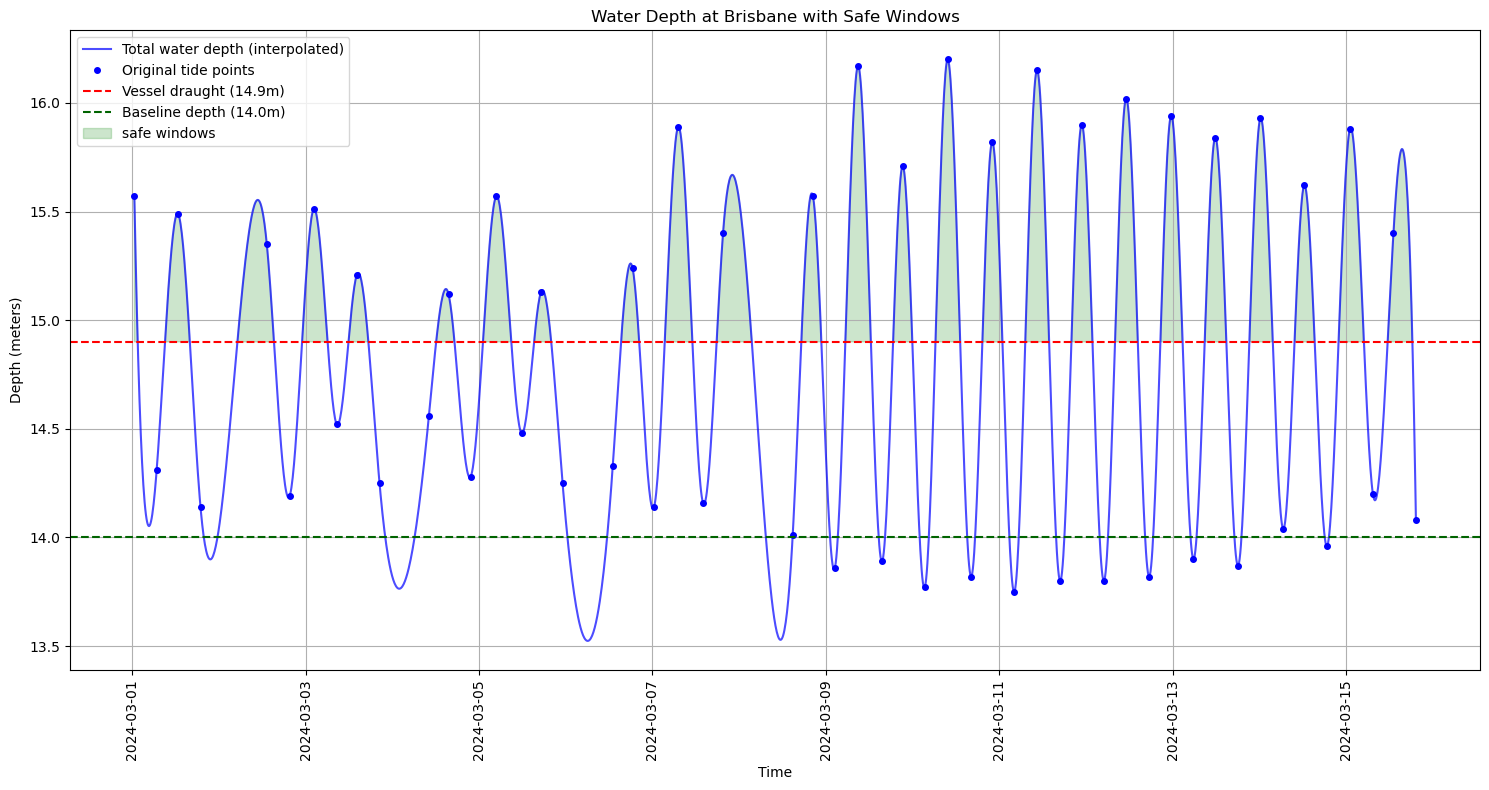

In [12]:
plt.figure(figsize=(15, 8))

plt.plot(interpolated_tides['TIDE_DATETIME'], interpolated_tides['TOTAL_DEPTH'], 'b-', label='Total water depth (interpolated)', alpha=0.7) # interpolated depth
plt.plot(port_tides['TIDE_DATETIME'], port_tides['TOTAL_DEPTH'], 'bo', label='Original tide points', markersize=4) # original tide points
plt.axhline(y=vessel_draught, color='red', linestyle='--', label=f'Vessel draught ({vessel_draught}m)') # vessel draught
plt.axhline(y=port_depth, color='darkgreen', linestyle='--', label=f'Baseline depth ({port_depth}m)') # port's minimum water depth

# Highlighting safe windows
plt.fill_between(interpolated_tides['TIDE_DATETIME'], vessel_draught, interpolated_tides['TOTAL_DEPTH'],where=interpolated_tides['IS_SAFE'], color='green', 
                alpha=0.2, label='safe windows')

plt.title(f'Water Depth at {port_name} with Safe Windows')
plt.xlabel('Time')
plt.ylabel('Depth (meters)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
interpolated_tides.head()

,TIDE_DATETIME,TIDE_HEIGHT_MT,TOTAL_DEPTH,IS_SAFE
0,2024-03-01 00:38:06.000000000,1.570000,15.570000,True
1,2024-03-01 00:48:44.613306653,1.424355,15.424355,True
2,2024-03-01 00:59:23.226613306,1.287110,15.287110,True
3,2024-03-01 01:10:01.839919959,1.158500,15.158500,True
4,2024-03-01 01:20:40.453226613,1.037926,15.037926,True


In [14]:
# finding the intervals
interpolated_tides['window_group'] = (~interpolated_tides['IS_SAFE']).cumsum()
safe_windows = interpolated_tides[interpolated_tides['IS_SAFE']].groupby('window_group').agg({
    'TIDE_DATETIME': ['first', 'last'],
    'TOTAL_DEPTH': ['min', 'max']
}).reset_index()

safe_windows.columns = ['window', 'start', 'end', 'min_depth', 'max_depth']

# calculating duration
safe_windows['duration_hours'] = (safe_windows['end'] - safe_windows['start']).dt.total_seconds() / 3600

print("\nSafe Navigation Windows:")
for _, window in safe_windows.iterrows():
    print(f"\nWindow {int(window['window'])}:")
    print(f"Start: {window['start'].strftime('%Y-%m-%d %H:%M')}")
    print(f"End: {window['end'].strftime('%Y-%m-%d %H:%M')}")
    print(f"Duration: {window['duration_hours']:.2f} hours")
    print(f"Depth range: {window['min_depth']:.2f}m - {window['max_depth']:.2f}m")


Safe Navigation Windows:

Window 0:
Start: 2024-03-01 00:38
End: 2024-03-01 01:31
Duration: 0.89 hours
Depth range: 14.93m - 15.57m

Window 42:
Start: 2024-03-01 09:08
End: 2024-03-01 15:53
Duration: 6.74 hours
Depth range: 14.91m - 15.49m

Window 116:
Start: 2024-03-02 05:11
End: 2024-03-02 15:07
Duration: 9.93 hours
Depth range: 14.91m - 15.55m

Window 160:
Start: 2024-03-02 23:06
End: 2024-03-03 06:01
Duration: 6.92 hours
Depth range: 14.92m - 15.51m

Window 192:
Start: 2024-03-03 11:53
End: 2024-03-03 17:22
Duration: 5.50 hours
Depth range: 14.90m - 15.22m

Window 297:
Start: 2024-03-04 12:11
End: 2024-03-04 17:09
Duration: 4.97 hours
Depth range: 14.91m - 15.14m

Window 341:
Start: 2024-03-05 01:08
End: 2024-03-05 08:45
Duration: 7.63 hours
Depth range: 14.91m - 15.57m

Window 377:
Start: 2024-03-05 15:19
End: 2024-03-05 19:56
Duration: 4.61 hours
Depth range: 14.91m - 15.14m

Window 486:
Start: 2024-03-06 15:27
End: 2024-03-06 20:14
Duration: 4.79 hours
Depth range: 14.92m - 15.

In [15]:
# Pre-processing functions
def get_tide_data(port_name, vessel_draught, start_date, num_days=14):
    """Get tide data and interpolate for smooth visualization"""
    try:
        # Convert and validate dates
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=num_days)
        
        # Get port and tide data
        port_depth = ports[ports['NAME'] == port_name]['APPROACH_MLLW_METERS'].iloc[0]
        port_tides = tide_heights[
            (tide_heights['PORT_NAME'] == port_name) & 
            (tide_heights['TIDE_DATETIME'].between(start_date, end_date))
        ].copy()
        
        if port_tides.empty:
            raise ValueError(f"No tide data available for {port_name} in the specified date range")
        
        # Calculate total depth for original points
        port_tides['TOTAL_DEPTH'] = port_depth + port_tides['TIDE_HEIGHT_MT']  # Added this line
        
        # Create interpolation DataFrame
        interpolated_tides = pd.DataFrame({
            'TIDE_DATETIME': pd.date_range(
                start=port_tides['TIDE_DATETIME'].min(),
                end=port_tides['TIDE_DATETIME'].max(),
                periods=2000
            )
        })
        
        # Perform interpolation
        times = port_tides['TIDE_DATETIME'].astype(np.int64) // 10**9
        heights = port_tides['TIDE_HEIGHT_MT'].values
        f = interp1d(times, heights, kind='cubic')
        
        interpolated_tides['timestamp'] = interpolated_tides['TIDE_DATETIME'].astype(np.int64) // 10**9
        interpolated_tides['TIDE_HEIGHT_MT'] = f(interpolated_tides['timestamp'])
        interpolated_tides['TOTAL_DEPTH'] = port_depth + interpolated_tides['TIDE_HEIGHT_MT']
        interpolated_tides['IS_SAFE'] = interpolated_tides['TOTAL_DEPTH'] >= vessel_draught
        
        return port_tides, interpolated_tides, port_depth
    
    except Exception as e:
        print(f"Error processing tide data: {str(e)}")
        return None, None, None


def get_safe_windows(interpolated_tides):
    """Calculate safe navigation windows"""
    try:
        # Group consecutive safe periods
        interpolated_tides['window_group'] = (~interpolated_tides['IS_SAFE']).cumsum()
        
        # Calculate window statistics
        safe_windows = interpolated_tides[interpolated_tides['IS_SAFE']].groupby('window_group').agg({
            'TIDE_DATETIME': ['first', 'last'],
            'TOTAL_DEPTH': ['min', 'max']
        }).reset_index()
        
        # Clean up and calculate duration
        safe_windows.columns = ['window', 'start', 'end', 'min_depth', 'max_depth']
        safe_windows['duration_hours'] = (safe_windows['end'] - safe_windows['start']).dt.total_seconds() / 3600
        
        return safe_windows
    
    except Exception as e:
        print(f"Error calculating safe windows: {str(e)}")
        return None

# Visualization
def plot_tide_windows(port_tides, interpolated_tides, port_depth, vessel_draught, port_name):
    """Create visualization of tide windows"""
    plt.figure(figsize=(15, 8))
    
    # Plot water depths
    plt.plot(interpolated_tides['TIDE_DATETIME'], interpolated_tides['TOTAL_DEPTH'], 'b-', label='Total water depth (interpolated)', alpha=0.7)
    
    plt.plot(port_tides['TIDE_DATETIME'], port_tides['TOTAL_DEPTH'], 'bo', label='Known Tide Points', markersize=4)
    
    # Add reference lines
    plt.axhline(y=vessel_draught, color='red', linestyle='--', label=f'Vessel Draught ({vessel_draught}m)')
    plt.axhline(y=port_depth, color='darkgreen', linestyle='--', label=f'Baseline Depth ({port_depth}m)')
    
    # Highlight safe windows
    plt.fill_between(interpolated_tides['TIDE_DATETIME'], vessel_draught, interpolated_tides['TOTAL_DEPTH'],where=interpolated_tides['IS_SAFE'], 
                    color='green', alpha=0.2,label='Safe navigation windows')
    
    # Format plot
    plt.title(f'Water depth at {port_name} with safe windows')
    plt.xlabel('Time')
    plt.ylabel('Depth (meters)')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Interactive function
def interactive_tide_windows(date, port_name="Brisbane", vessel_name="MBA ROSARIA"):
    """Interactive function to display tide windows and plot"""
    try:
        # Get vessel information
        vessel_draught = vessels[vessels['NAME'] == vessel_name]['DRAUGHT'].iloc[0]
        
        # Process tide data
        port_tides, interpolated_tides, port_depth = get_tide_data(port_name, vessel_draught, date)
        if port_tides is None:
            return
            
        # Calculate windows
        windows = get_safe_windows(interpolated_tides)
        if windows is None:
            return
            
        # Display results
        # Create visualization
        plot_tide_windows(port_tides, interpolated_tides, port_depth, vessel_draught, port_name)

        print(f"\nNavigation windows for {vessel_name} (draught: {vessel_draught}m) at {port_name} starting from {date}:")
        for _, window in windows.iterrows():
            print(f"\nWindow {int(window['window'])}:")
            print(f"Start: {window['start'].strftime('%Y-%m-%d %H:%M')}")
            print(f"End: {window['end'].strftime('%Y-%m-%d %H:%M')}")
            print(f"Duration: {window['duration_hours']:.2f} hours")
            print(f"Depth range: {window['min_depth']:.2f}m - {window['max_depth']:.2f}m")
        
        
        
        
    except Exception as e:
        print(f"Error in interactive function: {str(e)}")

# Widget setup
vessel_dropdown = widgets.Dropdown(
    options=vessels['NAME'].tolist(),
    description='Vessel:',
    value='MBA ROSARIA'
)

port_dropdown = widgets.Dropdown(
    options=ports['NAME'].tolist(),
    description='Port:',
    value='Brisbane'
)

date_picker = widgets.DatePicker(
    description='Start Date:',
    value=pd.to_datetime('2024-03-01').date()
)

# display interactive widget
interactive_widget = widgets.interactive(
    interactive_tide_windows,
    date=date_picker,
    port_name=port_dropdown,
    vessel_name=vessel_dropdown
)

display.display(interactive_widget)

interactive(children=(DatePicker(value=datetime.date(2024, 3, 1), description='Start Date:', step=1), Dropdown…